# Notebook 4.0 - Huấn luyện mô hình phân loại âm thanh


## Cell 1: Import thư viện
Cell này import các thư viện cần thiết:
- `numpy`, `torch`: xử lý mảng và deep learning
- `torch.nn`: các lớp neural network
- `DataLoader`, `Dataset`: xử lý dữ liệu
- `matplotlib`: hiển thị đồ thị
- `sklearn.metrics`: đánh giá mô hình
- `os`, `pandas`: xử lý file và dữ liệu
- `random`: tạo số ngẫu nhiên

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn import metrics
import os
import pandas as pd
import random

## Cell 2: Class AudioTransform
Class này thực hiện data augmentation cho mel spectrogram:
- `time_mask`: che phủ ngẫu nhiên một đoạn theo thời gian
- `freq_mask`: che phủ ngẫu nhiên một đoạn theo tần số
- `time_stretch`: kéo giãn/thu nhỏ theo thời gian
- Các tham số có thể điều chỉnh: xác suất áp dụng, độ dài mask, tỷ lệ stretch


In [2]:
# Cell 2: AudioTransform class for data augmentation
class AudioTransform:
    def __init__(self, time_mask_prob=0.5, freq_mask_prob=0.5, time_stretch_prob=0.5):
        self.time_mask_prob = time_mask_prob
        self.freq_mask_prob = freq_mask_prob
        self.time_stretch_prob = time_stretch_prob
        
    def time_mask(self, mel_spec, max_mask_length=0.1):
        """Apply time masking to mel spectrogram"""
        if random.random() < self.time_mask_prob:
            # Get mel spectrogram shape
            if len(mel_spec.shape) == 3:  # If has channel dimension
                _, n_mels, n_time = mel_spec.shape
                mel_spec = mel_spec[0]  # Take first channel
            else:
                n_mels, n_time = mel_spec.shape
                
            mask_length = int(n_time * max_mask_length)
            mask_start = random.randint(0, n_time - mask_length)
            mel_spec[:, mask_start:mask_start + mask_length] = 0
            
            if len(mel_spec.shape) == 2:  # If originally had channel dimension
                mel_spec = np.expand_dims(mel_spec, axis=0)
        return mel_spec
    
    def freq_mask(self, mel_spec, max_mask_length=0.1):
        """Apply frequency masking to mel spectrogram"""
        if random.random() < self.freq_mask_prob:
            # Get mel spectrogram shape
            if len(mel_spec.shape) == 3:  # If has channel dimension
                _, n_mels, n_time = mel_spec.shape
                mel_spec = mel_spec[0]  # Take first channel
            else:
                n_mels, n_time = mel_spec.shape
                
            mask_length = int(n_mels * max_mask_length)
            mask_start = random.randint(0, n_mels - mask_length)
            mel_spec[mask_start:mask_start + mask_length, :] = 0
            
            if len(mel_spec.shape) == 2:  # If originally had channel dimension
                mel_spec = np.expand_dims(mel_spec, axis=0)
        return mel_spec
    
    def time_stretch(self, mel_spec, stretch_range=(0.8, 1.2)):
        """Apply time stretching to mel spectrogram"""
        if random.random() < self.time_stretch_prob:
            # Get mel spectrogram shape
            if len(mel_spec.shape) == 3:  # If has channel dimension
                _, n_mels, n_time = mel_spec.shape
                mel_spec = mel_spec[0]  # Take first channel
            else:
                n_mels, n_time = mel_spec.shape
                
            stretch_factor = random.uniform(*stretch_range)
            new_time = int(n_time * stretch_factor)
            stretched = np.zeros((n_mels, new_time))
            
            for i in range(n_mels):
                stretched[i] = np.interp(
                    np.linspace(0, n_time, new_time),
                    np.arange(n_time),
                    mel_spec[i]
                )
            
            # Resize back to original size
            if stretch_factor > 1:
                # If stretch > 1, truncate
                mel_spec = stretched[:, :n_time]
            else:
                # If stretch < 1, pad
                mel_spec = np.pad(stretched, ((0, 0), (0, n_time - new_time)))
                
            if len(mel_spec.shape) == 2:  # If originally had channel dimension
                mel_spec = np.expand_dims(mel_spec, axis=0)
                
        return mel_spec
    
    def __call__(self, mel_spec):
        """Apply all augmentations"""
        mel_spec = self.time_mask(mel_spec)
        mel_spec = self.freq_mask(mel_spec)
        mel_spec = self.time_stretch(mel_spec)
        return mel_spec

## Cell 3: Class LoadData
Class này xử lý việc tải và chuẩn bị dữ liệu:
- Kế thừa từ `torch.utils.data.Dataset`
- Tự động tìm và phân loại các file .npy theo thư mục
- Hỗ trợ data augmentation thông qua transform
- Chuyển đổi dữ liệu thành tensor PyTorch


In [3]:
# Cell 3: LoadData class for dataset handling
class LoadData(Dataset):
    def __init__(self, data_dir, transform=None, custom_data=None):
        self.data_dir = data_dir
        self.transform = transform
        # Filter out metadata.csv from the list of classes
        self.classes = [d for d in sorted(os.listdir(data_dir)) 
                       if os.path.isdir(os.path.join(data_dir, d))]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        if custom_data is not None:
            # Convert label from string to index
            self.samples = [(path, self.class_to_idx[label]) for path, label in custom_data]
        else:
            self.samples = []
            for class_name in self.classes:
                class_dir = os.path.join(data_dir, class_name)
                for file_name in os.listdir(class_dir):
                    if file_name.endswith('.npy'):  # Mel spectrogram features
                        self.samples.append((os.path.join(class_dir, file_name), self.class_to_idx[class_name]))
    
    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        features = np.load(file_path)
        
        if len(features.shape) == 2:
            features = np.expand_dims(features, axis=0)
            
        if self.transform:
            features = self.transform(features)
            
        return torch.FloatTensor(features), torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.samples)


## Cell 4: Chuẩn bị dữ liệu
Cell này thực hiện:
- Đọc metadata và chia dữ liệu thành train/val/test (75/15/10)
- Tạo transform cho augmentation
- Tạo các dataset và dataloader
- In thông tin về phân phối dữ liệu

In [4]:
# Cell 4: Create datasets and dataloaders
# Read metadata to split train/test/val
metadata = pd.read_csv('../data/features/mel/metadata.csv')

# Create dataset with full paths
base_dir = '../data/features/mel'

# Create transform for augmentation
train_transform = AudioTransform(
    time_mask_prob=0.5,
    freq_mask_prob=0.5,
    time_stretch_prob=0.5
)

# Split data by class
train_data = []
val_data = []
test_data = []

for class_name in sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]):
    class_dir = os.path.join(base_dir, class_name)
    files = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
    
    # Shuffle files
    random.seed(42)
    random.shuffle(files)
    
    # Split with ratio 75-15-10
    n_files = len(files)
    n_train = int(0.75 * n_files)
    n_val = int(0.15 * n_files)
    
    # Split files into sets
    train_files = files[:n_train]
    val_files = files[n_train:n_train + n_val]
    test_files = files[n_train + n_val:]
    
    # Add full paths and labels
    train_data.extend([(os.path.join(class_dir, f), class_name) for f in train_files])
    val_data.extend([(os.path.join(class_dir, f), class_name) for f in val_files])
    test_data.extend([(os.path.join(class_dir, f), class_name) for f in test_files])

# Create datasets
train_ds = LoadData(base_dir, transform=train_transform, custom_data=train_data)
val_ds = LoadData(base_dir, transform=None, custom_data=val_data)
test_ds = LoadData(base_dir, transform=None, custom_data=test_data)

# Create DataLoaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8),
    'val': DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8), 
    'test': DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8),
}

# Print dataset information
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples: {len(test_ds)}")
print(f"Number of classes: {len(train_ds.classes)}")
print(f"Classes: {train_ds.classes}")

# Print class distribution information for each set
def get_class_distribution(dataset):
    distribution = {i: 0 for i in range(len(dataset.classes))}
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        distribution[label.item()] += 1
    return {dataset.classes[i]: count for i, count in distribution.items()}

print("\nClass distribution in training set:")
print(get_class_distribution(train_ds))
print("\nClass distribution in validation set:")
print(get_class_distribution(val_ds))
print("\nClass distribution in test set:")
print(get_class_distribution(test_ds))

Number of training samples: 1385
Number of validation samples: 274
Number of test samples: 194
Number of classes: 13
Classes: ['bat_den', 'bat_dieu_hoa', 'bat_quat', 'bat_tv', 'do_am', 'dong_rem', 'mo_rem', 'nhiet_do', 'tat_den', 'tat_dieu_hoa', 'tat_quat', 'tat_tv', 'unknown']

Class distribution in training set:
{'bat_den': 111, 'bat_dieu_hoa': 103, 'bat_quat': 105, 'bat_tv': 100, 'do_am': 111, 'dong_rem': 104, 'mo_rem': 105, 'nhiet_do': 110, 'tat_den': 110, 'tat_dieu_hoa': 104, 'tat_quat': 105, 'tat_tv': 105, 'unknown': 112}

Class distribution in validation set:
{'bat_den': 22, 'bat_dieu_hoa': 20, 'bat_quat': 21, 'bat_tv': 20, 'do_am': 22, 'dong_rem': 20, 'mo_rem': 21, 'nhiet_do': 22, 'tat_den': 22, 'tat_dieu_hoa': 20, 'tat_quat': 21, 'tat_tv': 21, 'unknown': 22}

Class distribution in test set:
{'bat_den': 16, 'bat_dieu_hoa': 15, 'bat_quat': 15, 'bat_tv': 14, 'do_am': 15, 'dong_rem': 15, 'mo_rem': 14, 'nhiet_do': 15, 'tat_den': 15, 'tat_dieu_hoa': 15, 'tat_quat': 14, 'tat_tv': 15,

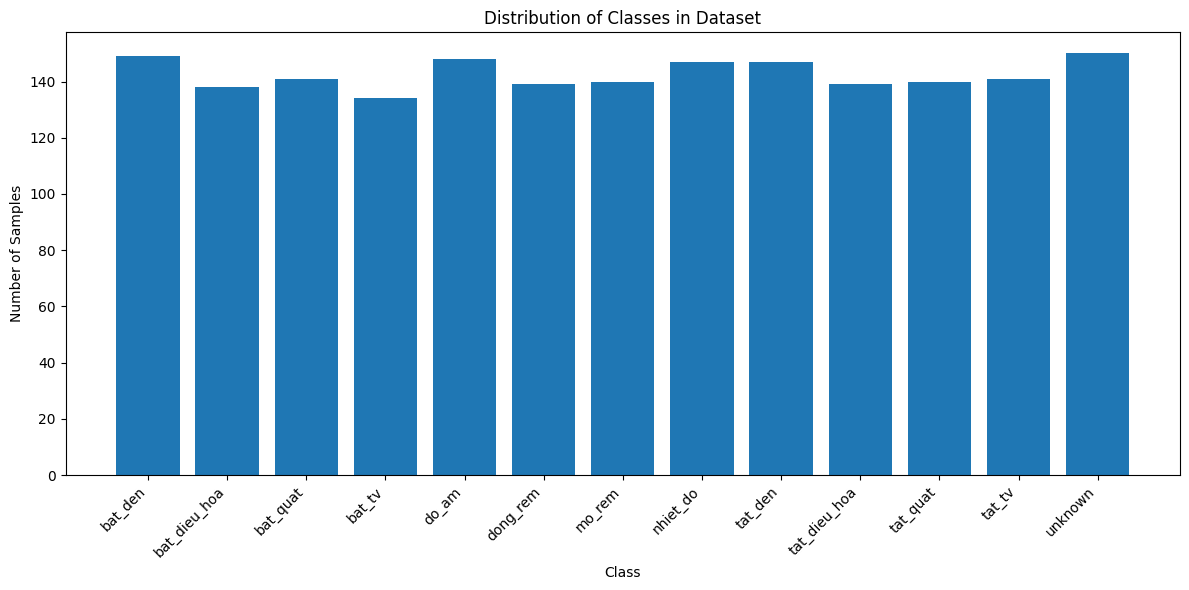


Class Distribution:
bat_den: 149 samples
bat_dieu_hoa: 138 samples
bat_quat: 141 samples
bat_tv: 134 samples
do_am: 148 samples
dong_rem: 139 samples
mo_rem: 140 samples
nhiet_do: 147 samples
tat_den: 147 samples
tat_dieu_hoa: 139 samples
tat_quat: 140 samples
tat_tv: 141 samples
unknown: 150 samples


In [5]:
# [OPTIONAL]
# Calculate number of samples for each class

# Create full dataset containing all data
full_ds = LoadData(base_dir, transform=None)

class_counts = {}
for class_name in full_ds.classes:
    class_dir = os.path.join(base_dir, class_name)
    class_counts[class_name] = len([f for f in os.listdir(class_dir) if f.endswith('.npy')])

# Draw bar plot
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Distribution of Classes in Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print detailed information
print("\nClass Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} samples")


## Cell 5: Định nghĩa mô hình ConvMixer
Mô hình ConvMixer được thiết kế đặc biệt cho xử lý âm thanh:
- Sử dụng residual connections
- Các lớp convolution depthwise và pointwise
- Adaptive pooling và fully connected layer cuối
- Hỗ trợ số lượng lớp tùy chỉnh (13 classes)

In [6]:
# Cell 5: ConvMixer model definition
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=13):
    return nn.Sequential(
        nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
            Residual(nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=kernel_size, groups=dim, padding="same"),
                nn.GELU(),
                nn.BatchNorm2d(dim)
            )),
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.GELU(),
            nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

## Cell 6: Khởi tạo mô hình và tham số
Cell này thực hiện:
- Khởi tạo mô hình ConvMixer
- Định nghĩa loss function (CrossEntropyLoss)
- Cấu hình optimizer (Adam) và learning rate scheduler
- Thiết lập các tham số training:
  - Số epoch: 25
  - Early stopping: 5 epochs
  - Learning rate: 0.001
  - Weight decay: 1e-4

In [7]:
# Cell 6: Initialize model and training parameters
# Initialize model
model = ConvMixer(dim=256, depth=8, n_classes=13)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Check and move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training parameters
num_epochs = 25
patience = 5  # Number of epochs to wait before early stopping
min_delta = 0.02  # Minimum improvement threshold

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.2,  # Stronger learning rate reduction
    patience=3,
    min_lr=1e-6  # Minimum learning rate
)

# Print model and device information
print(f"Model architecture:\n{model}")
print(f"Using device: {device}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Model architecture:
Sequential(
  (0): Conv2d(1, 256, kernel_size=(7, 7), stride=(7, 7))
  (1): GELU(approximate='none')
  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Sequential(
    (0): Residual(
      (fn): Sequential(
        (0): Conv2d(256, 256, kernel_size=(9, 9), stride=(1, 1), padding=same, groups=256)
        (1): GELU(approximate='none')
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (2): GELU(approximate='none')
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Residual(
      (fn): Sequential(
        (0): Conv2d(256, 256, kernel_size=(9, 9), stride=(1, 1), padding=same, groups=256)
        (1): GELU(approximate='none')
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    

## Cell 7: Vòng lặp huấn luyện
Cell này thực hiện quá trình huấn luyện:
- Training phase:
  - Forward pass và tính loss
  - Backward pass và cập nhật weights
  - Lưu training loss
- Validation phase:
  - Đánh giá trên tập validation
  - Tính accuracy và loss
  - Cập nhật learning rate
- Early stopping:
  - Lưu model tốt nhất
  - Dừng sớm nếu không cải thiện

In [8]:
# Cell 7: Training loop
# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0
best_index = 0
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate and store training loss
    epoch_train_loss = running_loss / len(dataloaders['train'])
    train_losses.append(epoch_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and store validation metrics
    epoch_val_loss = val_loss / len(dataloaders['val'])
    val_acc = 100 * correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_acc)
    print(f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

    # Update learning rate
    scheduler.step(val_acc)
    print(f'Current learning rate: {optimizer.param_groups[0]["lr"]:.6f}')

    # Early stopping check
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        patience_counter = 0
        # Save best model
        best_index = epoch
        torch.save(model.state_dict(), '../data/models/audio_classifier_best.pth')
        print(f'New best model saved! Validation Accuracy: {val_acc:.2f}%')
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs')
        
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

# Save final model
torch.save(model.state_dict(), '../data/models/audio_classifier_final.pth')
print("Training completed!")

Epoch 1/25, Training Loss: 2.0397
Validation Loss: 4.2893, Validation Accuracy: 18.25%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 18.25%
Epoch 2/25, Training Loss: 1.5273
Validation Loss: 1.1566, Validation Accuracy: 51.46%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 51.46%
Epoch 3/25, Training Loss: 1.1340
Validation Loss: 0.7677, Validation Accuracy: 68.98%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 68.98%
Epoch 4/25, Training Loss: 0.8048
Validation Loss: 0.6303, Validation Accuracy: 75.91%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 75.91%
Epoch 5/25, Training Loss: 0.5635
Validation Loss: 0.4279, Validation Accuracy: 83.58%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 83.58%
Epoch 6/25, Training Loss: 0.4993
Validation Loss: 0.3764, Validation Accuracy: 86.50%
Current learning rate: 0.001000
New best model saved! Validation Acc

In [9]:
print(f"\nBest validation accuracy: {best_val_acc:.2f}% of epoch {best_index + 1}")


Best validation accuracy: 98.18% of epoch 25


## Cell 8: Hiển thị kết quả huấn luyện
Cell này vẽ đồ thị:
- Training và validation loss
- Validation accuracy
- Learning rate schedule

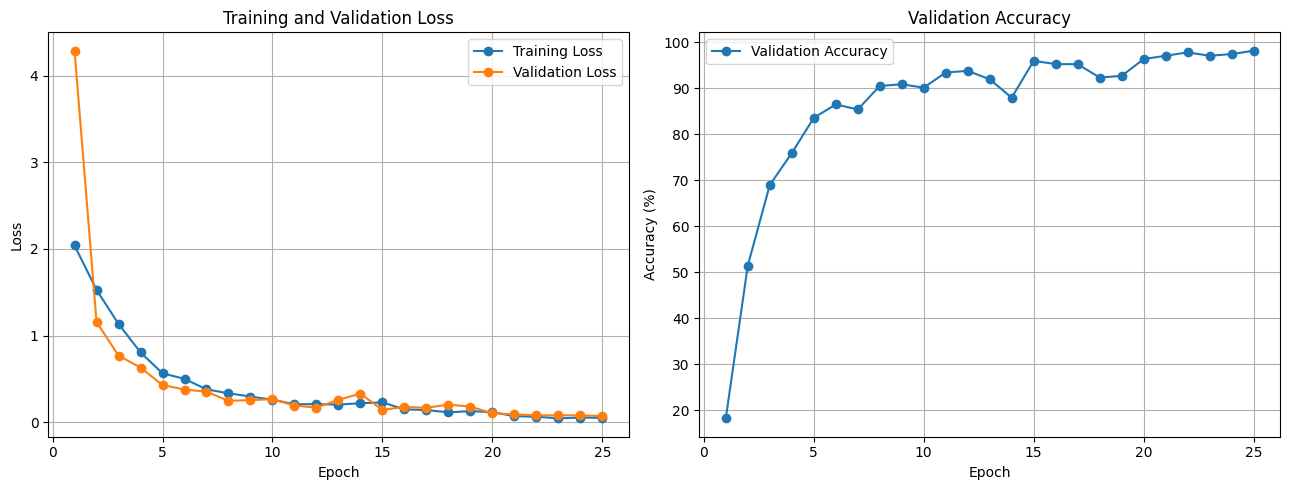

In [10]:
# Cell 8: Plot training and validation loss
plt.figure(figsize=(13, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Cell 9: Đánh giá mô hình
Cell này thực hiện đánh giá chi tiết:
- Load model tốt nhất
- Đánh giá trên tập test
- Vẽ confusion matrix
- In classification report
- Hiển thị các metrics:
  - Precision, recall, F1-score cho từng class
  - Accuracy tổng thể
  - Phân tích lỗi

Test Loss: 0.0896
Test Accuracy: 97.42%


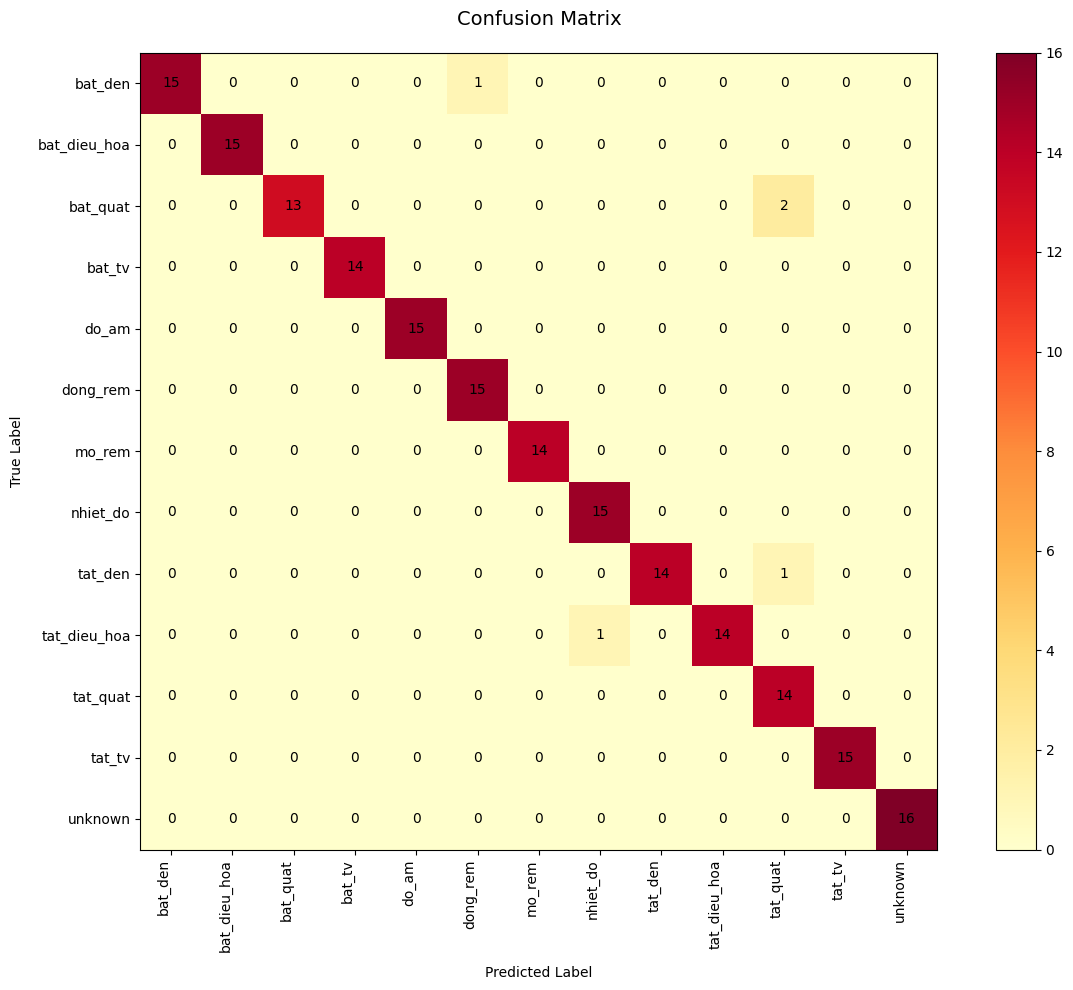


Classification Report:
              precision    recall  f1-score   support

     bat_den       1.00      0.94      0.97        16
bat_dieu_hoa       1.00      1.00      1.00        15
    bat_quat       1.00      0.87      0.93        15
      bat_tv       1.00      1.00      1.00        14
       do_am       1.00      1.00      1.00        15
    dong_rem       0.94      1.00      0.97        15
      mo_rem       1.00      1.00      1.00        14
    nhiet_do       0.94      1.00      0.97        15
     tat_den       1.00      0.93      0.97        15
tat_dieu_hoa       1.00      0.93      0.97        15
    tat_quat       0.82      1.00      0.90        14
      tat_tv       1.00      1.00      1.00        15
     unknown       1.00      1.00      1.00        16

    accuracy                           0.97       194
   macro avg       0.98      0.97      0.97       194
weighted avg       0.98      0.97      0.97       194



In [11]:
# Cell 9: Evaluate on test set and plot confusion matrix
def evaluate_model(model, dataloader, criterion, device):
    """Evaluate model on test set"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    test_acc = 100 * correct / total
    avg_loss = test_loss / len(dataloader)
    
    return avg_loss, test_acc, all_labels, all_predictions

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix"""
    plt.figure(figsize=(13, 10))
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=class_names
    )
    
    cm_display.plot(cmap='Blues')
    plt.title('Confusion Matrix', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Load best model
model.load_state_dict(torch.load('../data/models/audio_classifier_best.pth'))

# Evaluate model
test_loss, test_acc, all_labels, all_predictions = evaluate_model(
    model, dataloaders['test'], criterion, device
)

# Print results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

# Plot confusion matrix
plt.figure(figsize=(13, 10))
confusion_matrix = metrics.confusion_matrix(all_labels, all_predictions)

# Plot heatmap
plt.imshow(confusion_matrix, cmap='YlOrRd')
plt.colorbar()

# Add values to each cell
for i in range(len(full_ds.classes)):
    for j in range(len(full_ds.classes)):
        plt.text(j, i, f'{confusion_matrix[i, j]}',
                ha='center', va='center')

plt.title('Confusion Matrix', pad=20, fontsize=14)
plt.xlabel('Predicted Label', labelpad=10)
plt.ylabel('True Label', labelpad=10)

# Add labels
plt.xticks(range(len(full_ds.classes)), full_ds.classes, rotation=90, ha='right')
plt.yticks(range(len(full_ds.classes)), full_ds.classes)

plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(metrics.classification_report(all_labels, all_predictions, target_names=full_ds.classes))

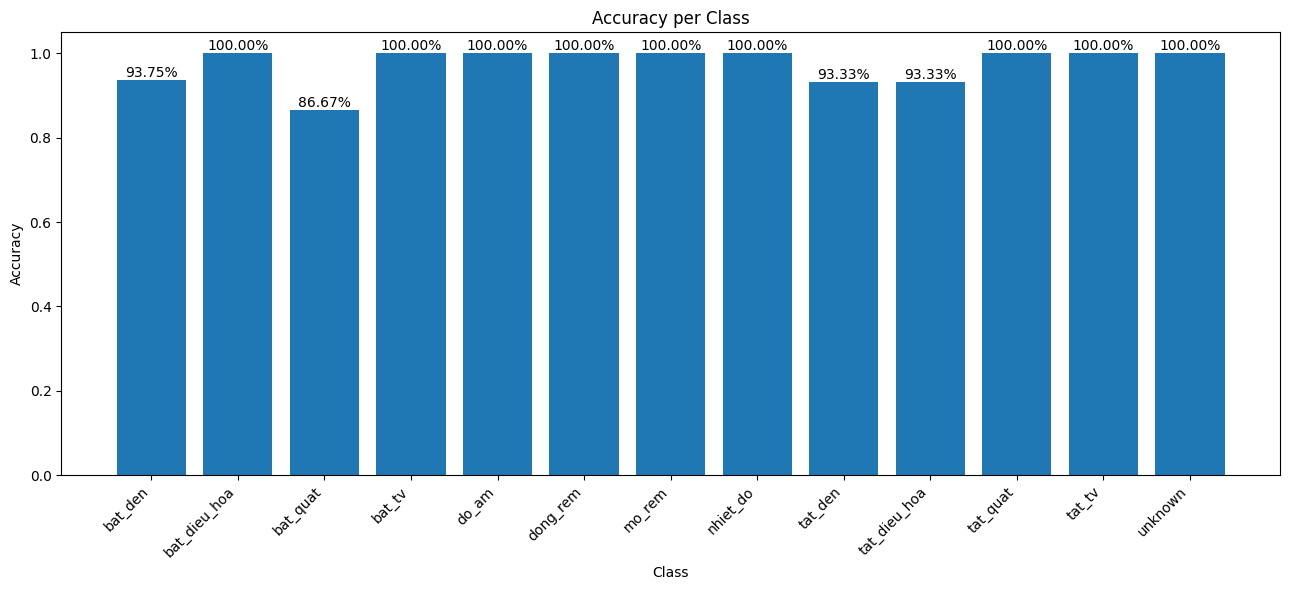

In [12]:
# [OPTIONAL]
def plot_class_accuracy(y_true, y_pred, class_names):
    # Calculate accuracy for each class
    class_accuracies = []
    for i in range(len(class_names)):
        mask = (y_true == i)
        if sum(mask) > 0:
            accuracy = np.mean(y_pred[mask] == y_true[mask])
            class_accuracies.append(accuracy)
        else:
            class_accuracies.append(0)
    
    # Create bar plot
    plt.figure(figsize=(13, 6))
    bars = plt.bar(class_names, class_accuracies)
    plt.title('Accuracy per Class')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45, ha='right')
    
    # Add accuracy values on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Call function to display
plot_class_accuracy(np.array(all_labels), np.array(all_predictions), full_ds.classes)

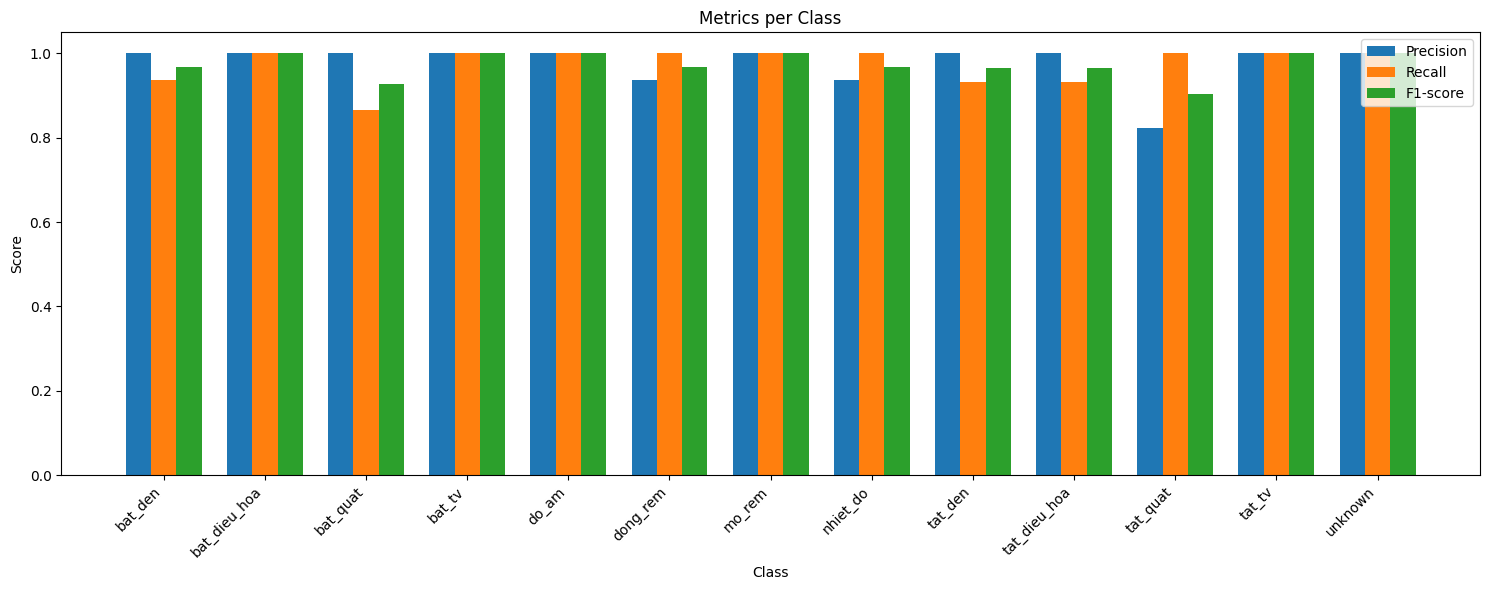

In [13]:
# [OPTIONAL]
def plot_metrics(y_true, y_pred, class_names):
    # Calculate precision, recall, f1-score for each class
    precision = metrics.precision_score(y_true, y_pred, average=None)
    recall = metrics.recall_score(y_true, y_pred, average=None)
    f1 = metrics.f1_score(y_true, y_pred, average=None)
    
    # Plot grouped bar chart
    x = np.arange(len(class_names))
    width = 0.25
    
    plt.figure(figsize=(15, 6))
    plt.bar(x - width, precision, width, label='Precision')
    plt.bar(x, recall, width, label='Recall')
    plt.bar(x + width, f1, width, label='F1-score')
    
    plt.title('Metrics per Class')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(np.array(all_labels), np.array(all_predictions), full_ds.classes)

Mục đích của notebook này là:
1. Huấn luyện mô hình phân loại âm thanh sử dụng ConvMixer
2. Áp dụng data augmentation để tăng độ robust
3. Theo dõi và tối ưu quá trình huấn luyện
4. Đánh giá chi tiết hiệu suất mô hình